In [1]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.cluster.hierarchy import dendrogram, linkage
import time
from datetime import datetime
import numpy as np
import math
import plotly.graph_objects as go
from plotly.graph_objs.scatter.marker import Line
from plotly.subplots import make_subplots
import plotly.express as px
from sklearn.metrics import silhouette_score

In [3]:
data = pd.read_excel('5years_database.xlsx', sheet_name='Data with Vix') #usecols=["Adj Close**", "Volume", "VIX-CLOSE"]

In [4]:
data['Date'] = pd.to_datetime(data['Date'], format='%m/%d/%Y') # convert 'Date' column to datetime
#data.set_index('Date', inplace=True)  # Set the 'Date' column as the index


In [5]:
# Calculate log returns
data['sp_log_return'] = np.log(data['Sp-close'] / data['Sp-close'].shift(1))
data.dropna(inplace=True)
data

,Date,Sp-close,Volume,Vix-close,sp_log_return
1,2023-02-21,3997.34,4121590000,22.87,0.001575
2,2023-02-17,4079.09,4045480000,20.02,0.020245
3,2023-02-16,4090.41,4143660000,20.17,0.002771
4,2023-02-15,4147.60,4075980000,18.23,0.013885
5,2023-02-14,4136.13,3929200000,18.91,-0.002769
...,...,...,...,...,...
1163,2018-07-09,2784.17,3070060000,12.69,-0.003467
1164,2018-07-06,2759.82,2590250000,13.37,-0.008784
1165,2018-07-05,2736.61,2980160000,14.97,-0.008446
1166,2018-07-03,2713.22,1911460000,16.14,-0.008584


In [6]:
# Normalize the Close column using min-max scaling
scaler = MinMaxScaler()    #x' = (x - min) / (max - min) Normalization
normalized_columns = ["Norm_Volume", "Norm_Vix_close", "Norm_sp_log_return"]
data[normalized_columns] = scaler.fit_transform(data[["Volume", "Vix-close", "sp_log_return"]])
normalized_columns = ["Norm_Volume", "Norm_Vix_close", 'Norm_sp_log_return']

Perform K-means clustering

In [7]:
# Perform k-means clustering
kmeans = KMeans(n_clusters=2, random_state=42)
data['kmeans_3'] = kmeans.fit_predict(data[normalized_columns])
data.head(5)

,Date,Sp-close,Volume,Vix-close,sp_log_return,Norm_Volume,Norm_Vix_close,Norm_sp_log_return,kmeans_3
1,2023-02-21,3997.34,4121590000,22.87,0.001575,0.325468,0.167316,0.419895,0
2,2023-02-17,4079.09,4045480000,20.02,0.020245,0.316700,0.127645,0.505799,0
3,2023-02-16,4090.41,4143660000,20.17,0.002771,0.328011,0.129733,0.425400,0
4,2023-02-15,4147.60,4075980000,18.23,0.013885,0.320214,0.102728,0.476535,0
5,2023-02-14,4136.13,3929200000,18.91,-0.002769,0.303303,0.112194,0.399907,0


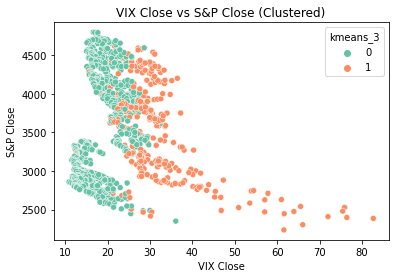

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.scatterplot(x=data['Vix-close'], y=data['Sp-close'], hue=data['kmeans_3'], palette='Set2')
plt.xlabel('VIX Close')
plt.ylabel('S&P Close')
plt.title('VIX Close vs S&P Close (Clustered)')
plt.show()

In [11]:
#Calculate the mean values of each feature within each cluster
centroids = data.groupby('kmeans_3').mean()
print(centroids)

             Sp-close        Volume  Vix-close  sp_log_return  Norm_Volume  \
kmeans_3                                                                     
0         3551.461927  3.823398e+09  18.585413      -0.000147     0.291114   
1         3523.464780  5.661702e+09  31.358983      -0.000857     0.502901   

          Norm_Vix_close  Norm_sp_log_return  
kmeans_3                                      
0               0.107676            0.411973  
1               0.285481            0.408705  


In [12]:
# Calculate returns
data['returns'] = data['Sp-close'].pct_change()
data.dropna(inplace=True)

In [13]:
cluster_stats = data.groupby('kmeans_3')['returns'].agg(['mean', 'count'])
cluster_stats['positive_returns'] = (data[data['returns'] > 0]
                                     .groupby('kmeans_3')['returns'].count())
cluster_stats['negative_returns'] = (data[data['returns'] < 0]
                                     .groupby('kmeans_3')['returns'].count())

print(cluster_stats)

              mean  count  positive_returns  negative_returns
kmeans_3                                                     
0        -0.000104    871               404               467
1        -0.000597    295               139               156


In [14]:
market_regime_map = {
  0: 'Low-volatility',
  1: 'High-volatility',

}

data['Market Regime'] = data['kmeans_3'].map(market_regime_map)
data.head(4)

,Date,Sp-close,Volume,Vix-close,sp_log_return,Norm_Volume,Norm_Vix_close,Norm_sp_log_return,kmeans_3,returns,Market Regime
2,2023-02-17,4079.09,4045480000,20.02,0.020245,0.316700,0.127645,0.505799,0,0.020451,Low-volatility
3,2023-02-16,4090.41,4143660000,20.17,0.002771,0.328011,0.129733,0.425400,0,0.002775,Low-volatility
4,2023-02-15,4147.60,4075980000,18.23,0.013885,0.320214,0.102728,0.476535,0,0.013981,Low-volatility
5,2023-02-14,4136.13,3929200000,18.91,-0.002769,0.303303,0.112194,0.399907,0,-0.002765,Low-volatility


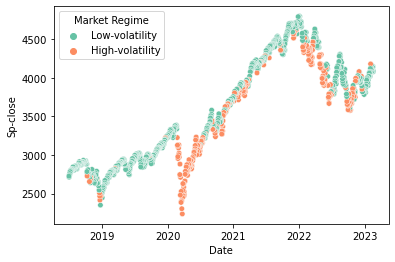

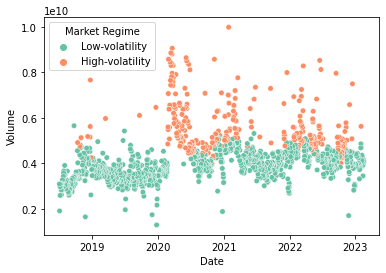

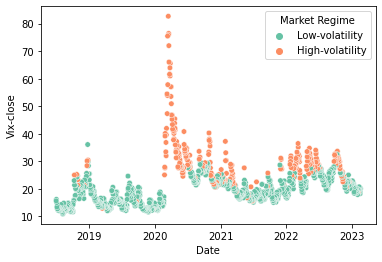

In [15]:
sns.scatterplot(x=data['Date'], y=data['Sp-close'], hue=data['Market Regime'], palette='Set2', s=30)
plt.show()

sns.scatterplot(x=data['Date'], y=data['Volume'], hue=data['Market Regime'], palette='Set2', s=30)
plt.show()

sns.scatterplot(x=data['Date'], y=data['Vix-close'], hue=data['Market Regime'], palette='Set2', s=30)
plt.show()

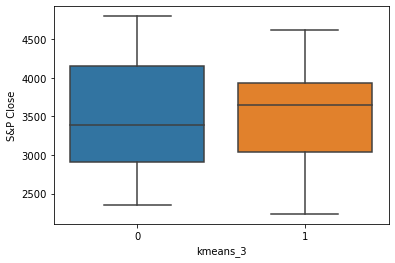

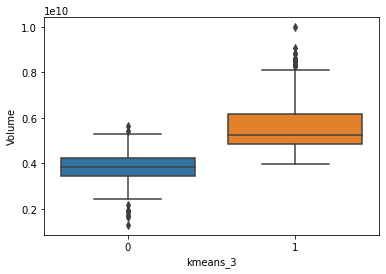

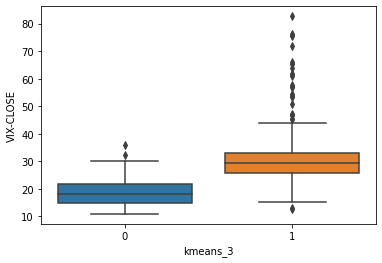

In [16]:
sns.boxplot(x='kmeans_3', y='Sp-close', data=data)
plt.ylabel('S&P Close')
plt.show()

sns.boxplot(x='kmeans_3', y='Volume', data=data)
plt.ylabel('Volume')
plt.show()

sns.boxplot(x='kmeans_3', y='Vix-close', data=data)
plt.ylabel('VIX-CLOSE')
plt.show()